# Electrical Consumption Timeseries Forcasting

### Dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Importing and Preprocessing Data

In [46]:
df = pd.read_csv("Data/PJME_hourly.csv")
df["Datetime"] = pd.DatetimeIndex(df["Datetime"])
df.set_index(df["Datetime"],inplace=True)
df.drop(columns = ["Datetime"],inplace=True)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [47]:
df.isnull().sum()

PJME_MW    0
dtype: int64

In [48]:
def Create_Features(data):
    data["hour"] = data.index.hour
    data["quarter"] = data.index.quarter
    data["year"] = data.index.year
    data["month"] = data.index.month
    data["day"] = data.index.day
    return data

In [49]:
df = Create_Features(df)
df.head()

,PJME_MW,hour,quarter,year,month,day
Datetime,,,,,,
2002-12-31 01:00:00,26498.0,1,4,2002,12,31
2002-12-31 02:00:00,25147.0,2,4,2002,12,31
2002-12-31 03:00:00,24574.0,3,4,2002,12,31
2002-12-31 04:00:00,24393.0,4,4,2002,12,31
2002-12-31 05:00:00,24860.0,5,4,2002,12,31


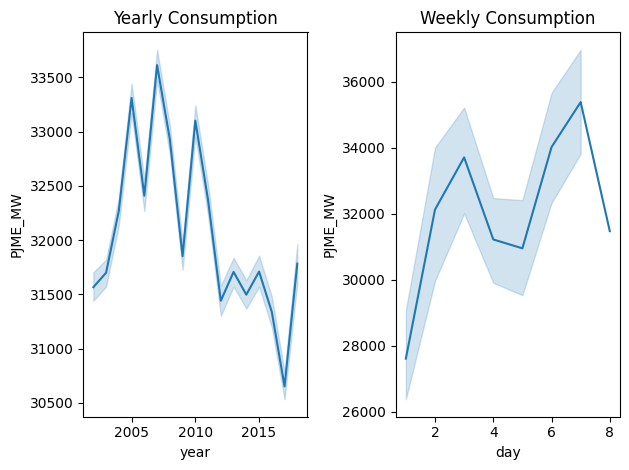

In [50]:
plt.subplot(1, 2, 1)

sns.lineplot(x = df["year"],y = df["PJME_MW"])
plt.title("Yearly Consumption")

plt.subplot(1, 2, 2)
wa = df.loc[(df.index >= "2003-01-01 00:00:00") & (df.index<= "2003-01-08 00:00:00")]


sns.lineplot(x = wa["day"],y = wa["PJME_MW"])
plt.title("Weekly Consumption")

plt.tight_layout()
plt.show()


In [51]:
train = df.loc[(df.index < "2015-01-01 00:00:00")]
test = df.loc[(df.index >= "2015-01-01 00:00:00")]

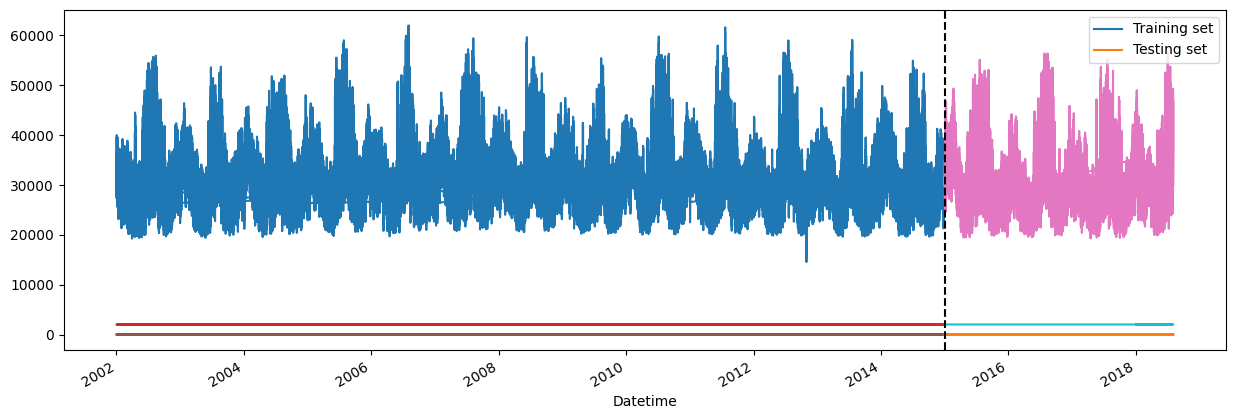

In [52]:
fig,ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax,label = "Training set")
test.plot(ax=ax,label = "Testing set")
ax.axvline("2015-01-01 00:00:00",color = "black",ls = "--")
ax.legend(["Training set","Testing set"])
plt.show()

### Generating Lag features

In [ ]:
def Create_lag_Features(data):
    data["lag_1"] = data["PJME_MW"].shift(24)
    data["lag_7"] = data["PJME_MW"].shift(7*24)
    return data

train = Create_lag_Features(data = train)
train.dropna(inplace=True)
train.sort_index()
train.head()

,PJME_MW,hour,quarter,year,month,day,lag_1,lag_7
Datetime,,,,,,,,
2002-12-24 01:00:00,27213.0,1,4,2002,12,24,27669.0,26498.0
2002-12-24 02:00:00,25643.0,2,4,2002,12,24,26162.0,25147.0
2002-12-24 03:00:00,24907.0,3,4,2002,12,24,25483.0,24574.0
2002-12-24 04:00:00,24721.0,4,4,2002,12,24,25045.0,24393.0
2002-12-24 05:00:00,25144.0,5,4,2002,12,24,25030.0,24860.0


In [54]:
test = Create_lag_Features(data = test)
test.dropna(inplace=True)
test.sort_index()
test.head()

,PJME_MW,hour,quarter,year,month,day,lag_1,lag_7
Datetime,,,,,,,,
2015-12-26 00:00:00,23104.0,0,4,2015,12,26,24704.0,32802.0
2015-12-24 01:00:00,23383.0,1,4,2015,12,24,22862.0,24305.0
2015-12-24 02:00:00,22053.0,2,4,2015,12,24,21494.0,23156.0
2015-12-24 03:00:00,21275.0,3,4,2015,12,24,20626.0,22514.0
2015-12-24 04:00:00,20912.0,4,4,2015,12,24,20165.0,22330.0


In [55]:
X_train = train.drop(columns = ["PJME_MW"])
y_train = train["PJME_MW"]

X_test = test.drop(columns = ["PJME_MW"])
y_test = test["PJME_MW"]

print(X_train.shape)
print(y_train.shape,end="\n\n")

print(X_test.shape)
print(y_test.shape)

(113758, 7)
(113758,)

(31272, 7)
(31272,)


### Training the model

In [56]:
model = xgb.XGBRegressor(n_estimators = 100,objective="reg:squarederror",device = "gpu",early_stopping_rounds = 50)
model.fit(X_train,y_train,verbose=True,eval_set=[(X_train,y_train),(X_test,y_test)])

[0]	validation_0-rmse:4896.87135	validation_1-rmse:4992.99191
[1]	validation_0-rmse:3901.04575	validation_1-rmse:4029.52193
[2]	validation_0-rmse:3291.57934	validation_1-rmse:3454.61038
[3]	validation_0-rmse:2937.23559	validation_1-rmse:3131.26256
[4]	validation_0-rmse:2737.37827	validation_1-rmse:2952.82415
[5]	validation_0-rmse:2626.26729	validation_1-rmse:2855.86240
[6]	validation_0-rmse:2561.85057	validation_1-rmse:2804.04936
[7]	validation_0-rmse:2523.01645	validation_1-rmse:2777.66448
[8]	validation_0-rmse:2495.78957	validation_1-rmse:2761.11528
[9]	validation_0-rmse:2476.71761	validation_1-rmse:2757.98054
[10]	validation_0-rmse:2464.67030	validation_1-rmse:2750.30820
[11]	validation_0-rmse:2448.87450	validation_1-rmse:2749.09050
[12]	validation_0-rmse:2433.94908	validation_1-rmse:2743.41401
[13]	validation_0-rmse:2423.72031	validation_1-rmse:2743.17310
[14]	validation_0-rmse:2417.16859	validation_1-rmse:2744.75409
[15]	validation_0-rmse:2403.60423	validation_1-rmse:2752.05000
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

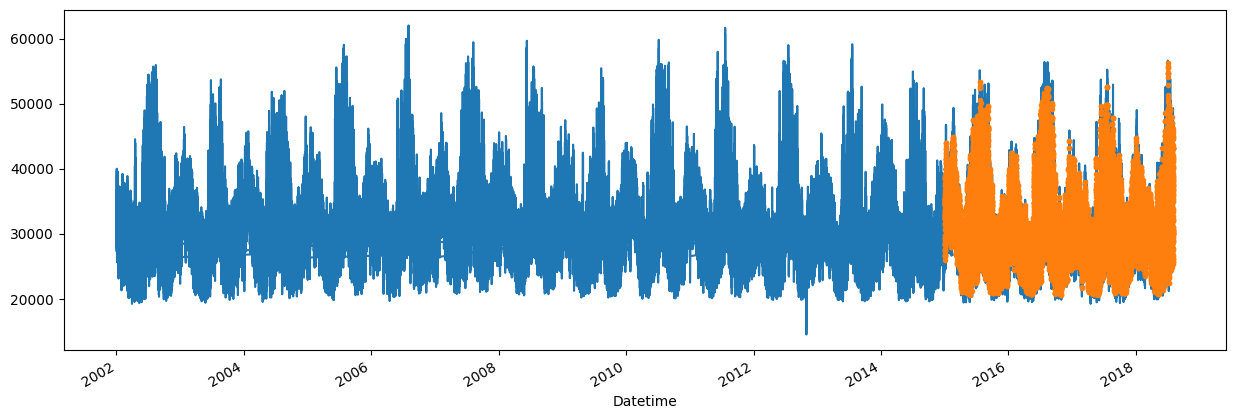

In [ ]:
test["prediction"] = model.predict(X_test)
df = df.merge(test["prediction"],how="left",left_index=True,right_index=True)

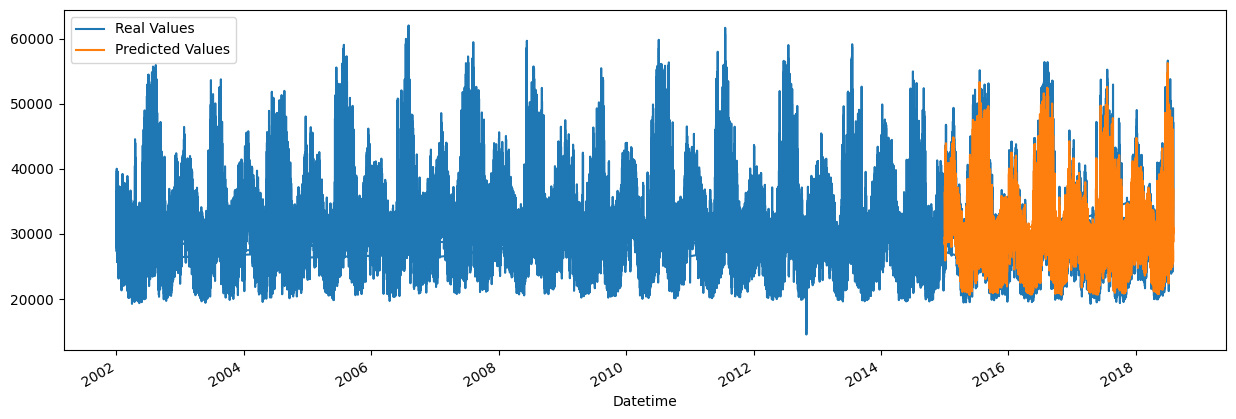

In [60]:
ax = df["PJME_MW"].plot(figsize=(15,5))
df["prediction"].plot(ax=ax)
ax.legend(["Real Values","Predicted Values"])
plt.show()